- Characterize which countries are about to reach (country_p0) or already reached the maximum number of infections per day (country_p1).
- Find the day and maximum of country_p1.
- Predict day and maximum of country_p0.
- Predict development for country_0
- Predict development for country_1

$e^{ax+b}$

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as keb
from scipy.optimize import curve_fit
from datetime import datetime as dtime
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading data
#path = "../input/covid19-global-forecasting-week-3/"
path = ""
data = pd.read_csv(path+"train.csv")
data= data.drop("Id", axis=1)
data.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,2020-01-22,0.0,0.0
1,NaN,Afghanistan,2020-01-23,0.0,0.0
2,NaN,Afghanistan,2020-01-24,0.0,0.0
3,NaN,Afghanistan,2020-01-25,0.0,0.0
4,NaN,Afghanistan,2020-01-26,0.0,0.0


In [3]:
data["isCountry"] = data.Province_State.isna()
data.Province_State[data.Province_State.isna()] = ""

In [4]:
data_non_countries = data[data.isCountry==False]
data_non_countries = data_non_countries[["Country_Region", "Date","ConfirmedCases", "Fatalities"]].groupby(["Country_Region", "Date"]).sum()
data_non_countries.reset_index(inplace=True)
data_non_countries["Province_State"] = np.nan
data_non_countries = data_non_countries[["Province_State", "Country_Region", "Date", "ConfirmedCases", "Fatalities"]]
data_non_countries["isCountry"] = True

data = pd.concat([data, data_non_countries])
data.reset_index(inplace=True)
data["Id"] = data.index
data = data.drop("index", axis=1)
data["Region"]= data.Country_Region 
data["Region"][~data.isCountry]= data.Country_Region + "-" + data.Province_State


In [5]:
number_of_rows = data.shape[0]
registers_count_by_region = data[["Id", "Region"]].groupby("Region").count()
registers_count_by_region.columns = ["Count"]
registers_count_by_region.reset_index(inplace=True)#
days = np.unique(data.Date)
n_days = len(days)
regions = np.unique(data.Region)

#new confirmed column
data["Id_by_Region"] = data[["Region", "Id"]].groupby("Region").cumcount()
data["PreviousConfirmed"] = data["ConfirmedCases"].shift()
data.loc[ data.Id_by_Region==0, "PreviousConfirmed"] = 0
data["NewConfirmed"]= data.ConfirmedCases - data.PreviousConfirmed

#new fatalities column
data["Id_by_Region"] = data[["Region", "Id"]].groupby("Region").cumcount()
data["PreviousFatalities"] = data["Fatalities"].shift()
data.loc[ data.Id_by_Region==0,"PreviousFatalities"] = 0
data["NewFatalities"]= data.Fatalities - data.PreviousFatalities

data["FirstConfirmed"] = data.apply(lambda x: x["ConfirmedCases"]>0, axis=1)
data["FirstFatality"] = data.apply(lambda x: x["Fatalities"]>0, axis=1)
data["DayFromFirstConfirmed"] = data[["FirstConfirmed", "Region"]].groupby("Region").cumsum()
data["DayFromFirstFatality"] = data[["FirstFatality", "Region"]].groupby("Region").cumsum()

data["TenConfirmed"] = data.apply(lambda x: x["ConfirmedCases"]>10, axis=1)
data["TenFatality"] = data.apply(lambda x: x["Fatalities"]>10, axis=1)
data["DayFromTenConfirmed"] = data[["TenConfirmed", "Region"]].groupby("Region").cumsum()
data["DayFromTenFatality"] = data[["TenFatality", "Region"]].groupby("Region").cumsum()

data["LogNewConfirmed"] = np.log(data["NewConfirmed"]+1) 
data["LogNewFatalities"] = np.log(data["NewFatalities"]+1)



In [6]:
print("Days:", days)
print("No. regions:", len(regions))
print("Regions:", regions)

Days: ['2020-01-22' '2020-01-23' '2020-01-24' '2020-01-25' '2020-01-26'
 '2020-01-27' '2020-01-28' '2020-01-29' '2020-01-30' '2020-01-31'
 '2020-02-01' '2020-02-02' '2020-02-03' '2020-02-04' '2020-02-05'
 '2020-02-06' '2020-02-07' '2020-02-08' '2020-02-09' '2020-02-10'
 '2020-02-11' '2020-02-12' '2020-02-13' '2020-02-14' '2020-02-15'
 '2020-02-16' '2020-02-17' '2020-02-18' '2020-02-19' '2020-02-20'
 '2020-02-21' '2020-02-22' '2020-02-23' '2020-02-24' '2020-02-25'
 '2020-02-26' '2020-02-27' '2020-02-28' '2020-02-29' '2020-03-01'
 '2020-03-02' '2020-03-03' '2020-03-04' '2020-03-05' '2020-03-06'
 '2020-03-07' '2020-03-08' '2020-03-09' '2020-03-10' '2020-03-11'
 '2020-03-12' '2020-03-13' '2020-03-14' '2020-03-15' '2020-03-16'
 '2020-03-17' '2020-03-18' '2020-03-19' '2020-03-20' '2020-03-21'
 '2020-03-22' '2020-03-23' '2020-03-24' '2020-03-25' '2020-03-26'
 '2020-03-27' '2020-03-28' '2020-03-29' '2020-03-30' '2020-03-31'
 '2020-04-01' '2020-04-02' '2020-04-03' '2020-04-04' '2020-04-05'
 '20

In [7]:
N = 5
data ["NewConfirmedSmoothed"] = np.convolve(data.NewConfirmed, np.ones((N,))/N, mode='same')
data ["NewFatalitiesSmoothed"] = np.convolve(data.NewFatalities, np.ones((N,))/N, mode='same')

In [8]:
data ["NewConfirmedSmoothed"] = 0
data ["NewFatalitiesSmoothed"] = 0

for region in regions:
    data ["NewConfirmedSmoothed"][data.Region==region] = np.convolve(data[data.Region==region].NewConfirmed, np.ones((N,))/N, mode='same')
    data ["NewFatalitiesSmoothed"][data.Region==region] = np.convolve(data[data.Region==region].NewFatalities, np.ones((N,))/N, mode='same')


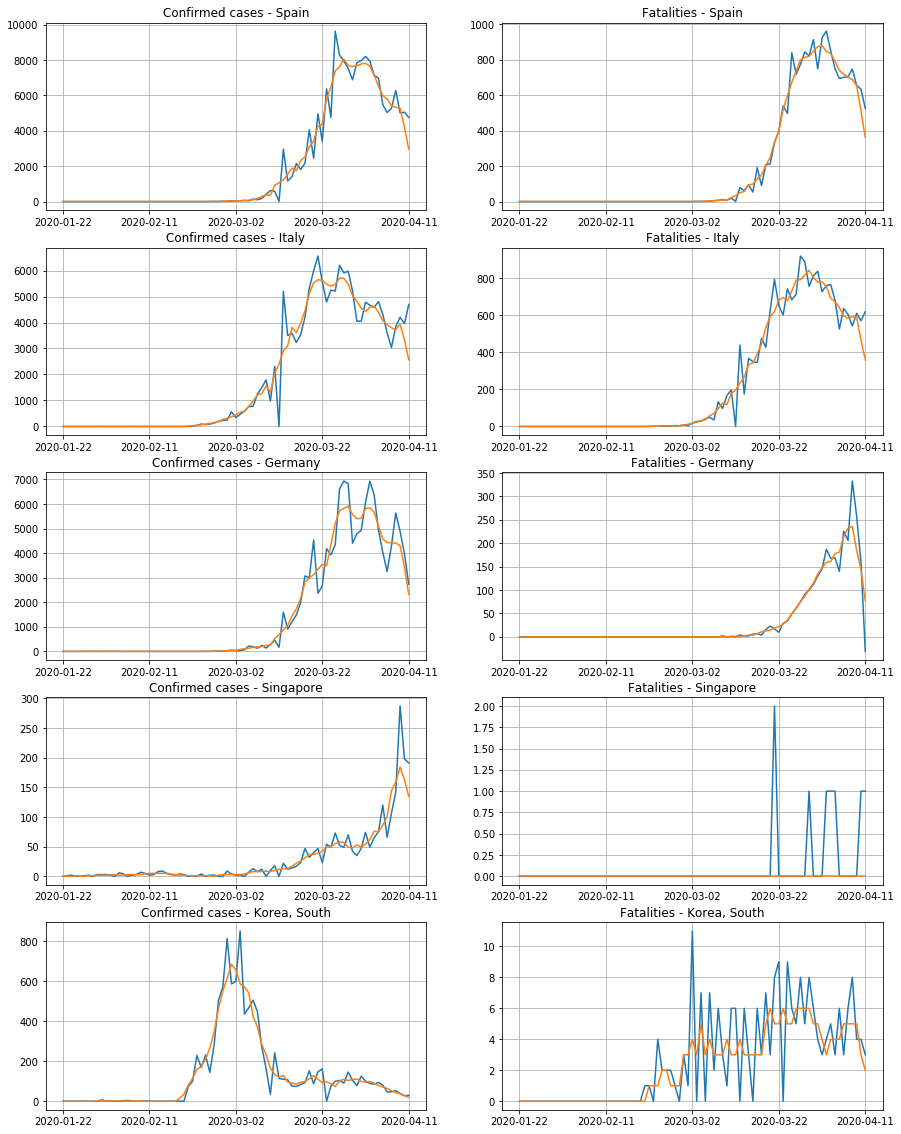

In [127]:
selected_countries = ["Spain", "Italy", "Germany", "Singapore", 'Korea, South']

fig, ax = plt.subplots(len(selected_countries),2, figsize=(15,20))

for i, country in enumerate(selected_countries):
    
    confirmed_country = data[data.Region==country].NewConfirmed
    confirmed_country_smoothed = data[data.Region==country].NewConfirmedSmoothed
    ax[i][0].plot(days, confirmed_country)
    ax[i][0].plot(days, confirmed_country_smoothed)
    ax[i][0].set_xticks(np.arange(0, n_days,20 ))

    ax[i][0].set_title("Confirmed cases - "+country)
    ax[i][0].grid()

for i, country in enumerate(selected_countries):
    
    fatalities_country = data[data.Region==country].NewFatalities
    fatalities_country_smoothed = data[data.Region==country].NewFatalitiesSmoothed
    ax[i][1].plot(days, fatalities_country)
    ax[i][1].plot(days, fatalities_country_smoothed)
    ax[i][1].set_xticks(np.arange(0, n_days,20 ))
    
    ax[i][1].set_title("Fatalities - "+country)
    ax[i][1].grid()
    
plt.savefig("cases")

In [ ]:
selected_countries = ["Spain", "Italy", "Germany", "Singapore", 'Korea, South']

fig, ax = plt.subplots(len(selected_countries),2, figsize=(15,10))

for i, country in enumerate(selected_countries):
    
    confirmed_country = data[data.Region==country].NewConfirmed
    confirmed_country_smoothed = data[data.Region==country].NewConfirmedSmoothed
    ax[i][0].plot(days, confirmed_country)
    ax[i][0].plot(days, confirmed_country_smoothed)
    ax[i][0].set_xticks(np.arange(0, n_days,20 ))

    ax[i][0].set_title("Confirmed cases")
    ax[i][0].grid()

for i, country in enumerate(selected_countries):
    
    fatalities_country = data[data.Region==country].NewFatalities
    fatalities_country_smoothed = data[data.Region==country].NewFatalitiesSmoothed
    ax[i][1].plot(days, fatalities_country)
    ax[i][1].plot(days, fatalities_country_smoothed)
    ax[i][1].set_xticks(np.arange(0, n_days,20 ))
    
    ax[i][1].set_title("Fatalities")
    ax[i][1].grid()

In [10]:
max_confirmed = data[["Region", "NewConfirmed"]].groupby("Region").max()
max_confirmed.reset_index(inplace=True)
max_confirmed.columns = ["Region", "MaxConfirmed"]

day_max_confirmed = data[["Region", "NewConfirmed"]].groupby("Region").idxmax()
day_max_confirmed2 = data[["DayFromTenConfirmed"]].iloc[day_max_confirmed.NewConfirmed]

day_max_confirmed.NewConfirmed = np.array(day_max_confirmed2.DayFromTenConfirmed)
day_max_confirmed.reset_index(inplace=True)
day_max_confirmed.columns = ["Region", "DayMaxConfirmed"]

current_day_count = data[["Region", "DayFromTenConfirmed"]].groupby("Region").max()
current_day_count .reset_index(inplace=True)
current_day_count.columns = ["Region", "CurrentDayCount"]



In [11]:
data_merged = max_confirmed.merge(day_max_confirmed, on = "Region").merge(current_day_count, on = "Region")
data_merged.head()

,Region,MaxConfirmed,DayMaxConfirmed,CurrentDayCount
0,Afghanistan,63.0,19.0,29.0
1,Albania,29.0,25.0,32.0
2,Algeria,185.0,31.0,39.0
3,Andorra,43.0,11.0,26.0
4,Angola,4.0,1.0,7.0


In [12]:
max_fatalities = data[["Region", "NewFatalities"]].groupby("Region").max()#smoothed?
max_fatalities.reset_index(inplace=True)
max_fatalities.columns = ["Region", "MaxFatalities"]

day_max_fatalities = data[["Region", "NewFatalities"]].groupby("Region").idxmax()#smoothed
day_max_fatalities2 = data[["DayFromTenFatality"]].iloc[day_max_fatalities.NewFatalities]#smoothed

day_max_fatalities.NewFatalities = np.array(day_max_fatalities2.DayFromTenFatality)
day_max_fatalities.reset_index(inplace=True)
day_max_fatalities.columns = ["Region", "DayMaxFatalities"]

data_merged = data_merged.merge(max_fatalities, on="Region").merge(day_max_fatalities, on = "Region")

In [13]:
data_merged["LastConfirmed"] = 0
data_merged["LastFatalities"] = 0
data_merged["LastLastConfirmed"] = 0
data_merged["LastLastFatalities"] = 0

for region in data_merged.Region:
    data_merged["LastConfirmed"][data_merged.Region==region] = data[data.Region==region]["NewConfirmed"].iloc[-1]
    data_merged["LastFatalities"][data_merged.Region==region] = data[data.Region==region]["NewFatalities"].iloc[-1]
    data_merged["LastLastConfirmed"][data_merged.Region==region] = data[data.Region==region]["NewConfirmed"].iloc[-2]
    data_merged["LastLastFatalities"][data_merged.Region==region] = data[data.Region==region]["NewFatalities"].iloc[-2]


In [14]:
data_merged

,Region,MaxConfirmed,DayMaxConfirmed,CurrentDayCount,MaxFatalities,DayMaxFatalities,LastConfirmed,LastFatalities,LastLastConfirmed,LastLastFatalities
0,Afghanistan,63.0,19.0,29.0,4.0,1.0,34,3,37,0
1,Albania,29.0,25.0,32.0,4.0,2.0,17,0,7,0
2,Algeria,185.0,31.0,39.0,30.0,21.0,64,19,95,21
3,Andorra,43.0,11.0,26.0,4.0,1.0,0,0,18,1
4,Angola,4.0,1.0,7.0,2.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
312,Vietnam,19.0,44.0,64.0,0.0,0.0,1,0,2,0
313,West Bank and Gaza,33.0,28.0,36.0,1.0,0.0,1,0,4,1
314,Western Sahara,4.0,0.0,0.0,0.0,0.0,0,0,0,0
315,Zambia,9.0,1.0,18.0,1.0,0.0,0,0,1,1


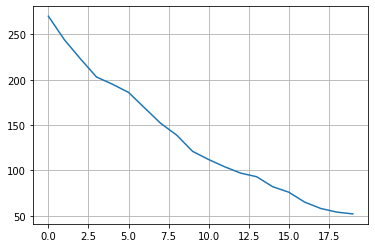

In [15]:
count = []
for threshold in range(20):
    
    country_type = data_merged[["DayMaxConfirmed", "CurrentDayCount"]].apply(lambda x: (x[1]-x[0])>threshold, 1)
    count.append(np.sum(country_type))
    
plt.plot(range(20), count)
plt.grid()

In [16]:
data_merged["CountryType"] = data_merged[["DayMaxConfirmed", "CurrentDayCount"]].apply(lambda x: int((x[1]-x[0])>7), 1)

In [17]:
list(data_merged[data_merged.CountryType == 1].Region)

['Afghanistan',
 'Algeria',
 'Andorra',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Australia-Australian Capital Territory',
 'Australia-New South Wales',
 'Australia-Northern Territory',
 'Australia-Queensland',
 'Australia-South Australia',
 'Australia-Tasmania',
 'Australia-Victoria',
 'Australia-Western Australia',
 'Austria',
 'Bahamas',
 'Barbados',
 'Belgium',
 'Brunei',
 'Bulgaria',
 'Cambodia',
 'Cameroon',
 'Canada-Alberta',
 'Canada-British Columbia',
 'Canada-Manitoba',
 'Canada-New Brunswick',
 'Canada-Newfoundland and Labrador',
 'Canada-Prince Edward Island',
 'Canada-Saskatchewan',
 'China',
 'China-Anhui',
 'China-Beijing',
 'China-Chongqing',
 'China-Fujian',
 'China-Gansu',
 'China-Guangdong',
 'China-Guangxi',
 'China-Guizhou',
 'China-Hainan',
 'China-Hebei',
 'China-Heilongjiang',
 'China-Henan',
 'China-Hong Kong',
 'China-Hubei',
 'China-Hunan',
 'China-Jiangsu',
 'China-Jiangxi',
 'China-Jilin',
 'China-Liaoning',
 'China-Macau',
 'China-N

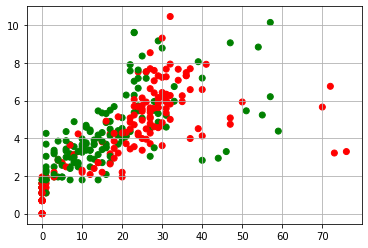

In [18]:
color = ["red", "green"]
color_assigned = [color[i] for i in data_merged.CountryType]
plt.scatter(data_merged.DayMaxConfirmed, np.log(data_merged.MaxConfirmed), c=color_assigned)
plt.grid()

Insight: there is a strong linear relationship between the maximum number of infected per day and the day when it occurs. It is unterstandable, countries which good measures reach the maximum earlier and this number is relative lower.

# Computing desaccelerating rate

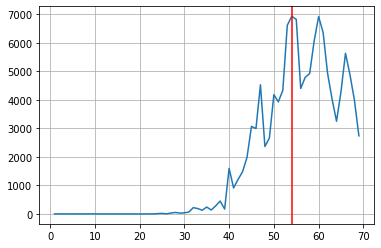

In [138]:
temp_data = data[data.Region=="Germany"][data.TenConfirmed==True]
day_max_confirmed = int(data_merged[data_merged.Region=="Germany"].DayMaxConfirmed)
max_confirmed = int(data_merged[data_merged.Region=="Germany"].MaxConfirmed)
plt.plot(temp_data.DayFromTenConfirmed,temp_data.NewConfirmed)
plt.axvline(x=day_max_confirmed, c="red")
plt.grid()
plt.savefig("confirmed_germany.png")

Desacelerating rate: [-0.04758327]


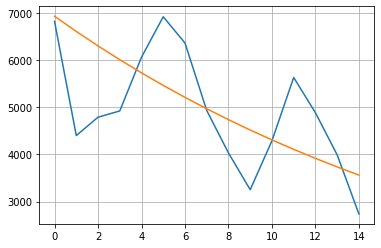

In [139]:
from scipy.optimize import curve_fit

def linear(x, a):
    
    return a*x

pos_data = temp_data[temp_data.DayFromTenConfirmed>int(day_max_confirmed)].NewConfirmed
x_data = np.arange(pos_data.shape[0])
log_data = np.log(pos_data)-np.log(max_confirmed)

popt, pcov = curve_fit(linear, x_data, log_data)
pred = linear(x_data, *popt)
plt.plot(x_data, np.exp(log_data+np.log(max_confirmed)))
plt.plot(x_data, np.exp(pred+np.log(max_confirmed)))
plt.grid()
plt.savefig("confirmed_germany_phase1.png")
print("Desacelerating rate:", popt)

In [21]:
data_merged["DesacceleratingRateConfirmed"] = 0.0
data_merged["DesacceleratingRateFatalities"] = 0.0

for region in regions:
    
    temp_data = data[data.Region==region][data.TenConfirmed==True]
    
    if(temp_data.shape[0]>0):
        
        temp_data_merged = data_merged[data_merged.Region==region]

        country_type = int(temp_data_merged.CountryType)
        
        if(country_type==1):
            

            day_max_confirmed = int(temp_data_merged.DayMaxConfirmed)
            max_confirmed = int(temp_data_merged.MaxConfirmed)
            day_max_fatalities = int(temp_data_merged.DayMaxFatalities)
            max_fatalities = int(temp_data_merged.MaxFatalities)
            isCountry = temp_data.isCountry.iloc[0]
            
            pos_data = temp_data[temp_data.DayFromTenConfirmed>int(day_max_confirmed)].NewConfirmed
            x_data = np.arange(pos_data.shape[0])
            log_data = np.log(pos_data.clip(0)+1)-np.log(max_confirmed+1)
            popt, pcov = curve_fit(linear, x_data, log_data)        
            data_merged.loc[data_merged.Region==region, "DesacceleratingRateConfirmed"]= popt[0]
            
            pos_data = temp_data[temp_data.DayFromTenConfirmed>int(day_max_fatalities)].NewFatalities
            x_data = np.arange(pos_data.shape[0])
            log_data = np.log(pos_data.clip(0)+1)-np.log(max_fatalities+1)
            popt, pcov = curve_fit(linear, x_data, log_data)        
            data_merged.loc[data_merged.Region==region, "DesacceleratingRateFatalities"]= popt[0]

## Adding demographic data

In [22]:
#obtain the country name
path2 = ""
country_region = data[["Region", "Country_Region", "isCountry"]].drop_duplicates()
data_merged = data_merged.merge(country_region, on="Region", how="left")
data_merged.head()

,Region,MaxConfirmed,DayMaxConfirmed,CurrentDayCount,MaxFatalities,DayMaxFatalities,LastConfirmed,LastFatalities,LastLastConfirmed,LastLastFatalities,CountryType,DesacceleratingRateConfirmed,DesacceleratingRateFatalities,Country_Region,isCountry
0,Afghanistan,63.0,19.0,29.0,4.0,1.0,34,3,37,0,1,-0.103983,-0.061877,Afghanistan,True
1,Albania,29.0,25.0,32.0,4.0,2.0,17,0,7,0,0,0.000000,0.000000,Albania,True
2,Algeria,185.0,31.0,39.0,30.0,21.0,64,19,95,21,1,-0.166469,-0.049068,Algeria,True
3,Andorra,43.0,11.0,26.0,4.0,1.0,0,0,18,1,1,-0.116588,-0.054269,Andorra,True
4,Angola,4.0,1.0,7.0,2.0,0.0,0,0,0,0,0,0.000000,0.000000,Angola,True


In [23]:
gini = pd.read_csv(path2+"gini.csv")
gini_2019 = gini[["country","2019"]]
gini_2019.columns = ["Country_Region", "Gini"]
gini_2019.head()

,Country_Region,Gini
0,Afghanistan,36.8
1,Albania,29.0
2,Algeria,27.6
3,Andorra,40.0
4,Angola,42.6


In [24]:
population = pd.read_csv(path2+"population_total.csv")
population_2019 = population[["country", "2019"]]
population_2019.columns = ["Country_Region", "Population"]
population_2019.Population = population_2019.Population/1000000
population_2019.head()

,Country_Region,Population
0,Afghanistan,38.0000
1,Albania,2.8800
2,Algeria,43.1000
3,Andorra,0.0771
4,Angola,31.8000


In [25]:
health_system = pd.read_csv(path2+"government_health_spending_of_total_gov_spending_percent.csv")
health_system_2010 = health_system [["country", "2010"]]
health_system_2010.columns = ["Country_Region", "HealthSystem"]
health_system_2010.head()

,Country_Region,HealthSystem
0,Afghanistan,1.59
1,Albania,8.42
2,Algeria,8.12
3,Andorra,21.30
4,Angola,7.18


In [26]:
gdp = pd.read_csv(path2+"gdp_total_yearly_growth.csv")
gdp_2013 = gdp[["country", "2013"]]
gdp_2013.columns = ["Country_Region", "GDP"]
gdp_2013.head()

,Country_Region,GDP
0,Afghanistan,4.47
1,Albania,2.06
2,Algeria,2.99
3,Andorra,NaN
4,Angola,3.79


In [27]:
life_expectancy = pd.read_csv(path2+"life_expectancy_years.csv")
life_expectancy_2019 = life_expectancy[["country", "2019"]]
life_expectancy_2019.columns = ["Country_Region", "LifeExpectancy"]
life_expectancy_2019.head()

,Country_Region,LifeExpectancy
0,Afghanistan,64.1
1,Albania,78.5
2,Algeria,78.1
3,Andorra,NaN
4,Angola,65.0


In [28]:
smokers = pd.read_csv(path2+"smoking_adults_percent_of_population_over_age_15.csv")
smokers_2005 = smokers[["country", "2005"]]
smokers_2005.columns = ["Country_Region", "Smokers"]
smokers_2005.head()

,Country_Region,Smokers
0,Albania,22.4
1,Algeria,15.2
2,Andorra,32.9
3,Argentina,30.0
4,Armenia,29.6


In [29]:
demographic_data = gini_2019.merge(population_2019, on="Country_Region", how="outer")
demographic_data = demographic_data.merge(health_system_2010, on="Country_Region", how="outer")
demographic_data = demographic_data.merge(gdp_2013, on = "Country_Region", how="outer")
demographic_data = demographic_data.merge(life_expectancy_2019, on = "Country_Region", how="outer")
demographic_data = demographic_data.merge(smokers_2005, on = "Country_Region", how="outer")
demographic_data

,Country_Region,Gini,Population,HealthSystem,GDP,LifeExpectancy,Smokers
0,Afghanistan,36.8,38.0000,1.59,4.47,64.1,NaN
1,Albania,29.0,2.8800,8.42,2.06,78.5,22.4
2,Algeria,27.6,43.1000,8.12,2.99,78.1,15.2
3,Andorra,40.0,0.0771,21.30,NaN,NaN,32.9
4,Angola,42.6,31.8000,7.18,3.79,65.0,NaN
...,...,...,...,...,...,...,...
190,Venezuela,46.9,28.5000,7.52,0.92,75.1,29.8
191,Vietnam,35.3,96.5000,7.79,5.41,74.7,24.3
192,Yemen,36.7,29.2000,4.33,4.48,68.1,NaN
193,Zambia,57.1,17.9000,15.60,5.85,64.0,13.4


In [30]:
country_names_dict ={"Congo, Dem. Rep.": "Congo (Kinshasa)",
                     "Congo, Rep.": "Congo (Brazzaville)",
                     "Czech Republic": "Czechia",
                     "Kyrgyz Republic": "Kyrgyzstan",
                     "South Korea": "Korea, South",
                     "Lao": "Laos",
                     "St. Kitts and Nevis":"Saint Kitts and Nevis",
                     "St. Lucia":"Saint Lucia",
                     "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
                     "Slovak Republic": "Slovakia",
                     "United States": "US"}
demographic_data["Country_Region"] = demographic_data["Country_Region"].replace(country_names_dict)

In [31]:
data_merged2 = data_merged.merge(demographic_data, on="Country_Region", how="outer")
data_merged2

,Region,MaxConfirmed,DayMaxConfirmed,CurrentDayCount,MaxFatalities,DayMaxFatalities,LastConfirmed,LastFatalities,LastLastConfirmed,LastLastFatalities,...,DesacceleratingRateConfirmed,DesacceleratingRateFatalities,Country_Region,isCountry,Gini,Population,HealthSystem,GDP,LifeExpectancy,Smokers
0,Afghanistan,63.0,19.0,29.0,4.0,1.0,34.0,3.0,37.0,0.0,...,-0.103983,-0.061877,Afghanistan,True,36.8,38.0000,1.59,4.47,64.1,NaN
1,Albania,29.0,25.0,32.0,4.0,2.0,17.0,0.0,7.0,0.0,...,0.000000,0.000000,Albania,True,29.0,2.8800,8.42,2.06,78.5,22.4
2,Algeria,185.0,31.0,39.0,30.0,21.0,64.0,19.0,95.0,21.0,...,-0.166469,-0.049068,Algeria,True,27.6,43.1000,8.12,2.99,78.1,15.2
3,Andorra,43.0,11.0,26.0,4.0,1.0,0.0,0.0,18.0,1.0,...,-0.116588,-0.054269,Andorra,True,40.0,0.0771,21.30,NaN,NaN,32.9
4,Angola,4.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,Angola,True,42.6,31.8000,7.18,3.79,65.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Tonga,NaN,37.5,0.1040,12.90,1.10,72.0,39.0
333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Turkmenistan,NaN,46.4,5.9400,9.86,9.78,70.3,NaN
334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Tuvalu,NaN,39.1,0.0117,14.40,NaN,NaN,NaN
335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Vanuatu,NaN,37.6,0.3000,18.20,-1.02,65.0,28.8


In [32]:
list(data_merged2[np.isnan(data_merged2.MaxConfirmed) | np.isnan(data_merged2.Gini)].Country_Region)

['Burma',
 'Cabo Verde',
 'Diamond Princess',
 'Eswatini',
 'Kosovo',
 'MS Zaandam',
 'Taiwan*',
 'West Bank and Gaza',
 'Western Sahara',
 'Cape Verde',
 'Comoros',
 'Kiribati',
 'Lesotho',
 'Marshall Islands',
 'Micronesia, Fed. Sts.',
 'Myanmar',
 'Nauru',
 'North Korea',
 'Palau',
 'Palestine',
 'Samoa',
 'Solomon Islands',
 'Swaziland',
 'Tajikistan',
 'Tonga',
 'Turkmenistan',
 'Tuvalu',
 'Vanuatu',
 'Yemen']

In [33]:
data_merged3 = data_merged2[~np.isnan(data_merged2.MaxConfirmed)]
data_merged3

,Region,MaxConfirmed,DayMaxConfirmed,CurrentDayCount,MaxFatalities,DayMaxFatalities,LastConfirmed,LastFatalities,LastLastConfirmed,LastLastFatalities,...,DesacceleratingRateConfirmed,DesacceleratingRateFatalities,Country_Region,isCountry,Gini,Population,HealthSystem,GDP,LifeExpectancy,Smokers
0,Afghanistan,63.0,19.0,29.0,4.0,1.0,34.0,3.0,37.0,0.0,...,-0.103983,-0.061877,Afghanistan,True,36.8,38.0000,1.59,4.47,64.1,NaN
1,Albania,29.0,25.0,32.0,4.0,2.0,17.0,0.0,7.0,0.0,...,0.000000,0.000000,Albania,True,29.0,2.8800,8.42,2.06,78.5,22.4
2,Algeria,185.0,31.0,39.0,30.0,21.0,64.0,19.0,95.0,21.0,...,-0.166469,-0.049068,Algeria,True,27.6,43.1000,8.12,2.99,78.1,15.2
3,Andorra,43.0,11.0,26.0,4.0,1.0,0.0,0.0,18.0,1.0,...,-0.116588,-0.054269,Andorra,True,40.0,0.0771,21.30,NaN,NaN,32.9
4,Angola,4.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,Angola,True,42.6,31.8000,7.18,3.79,65.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,Vietnam,19.0,44.0,64.0,0.0,0.0,1.0,0.0,2.0,0.0,...,-0.107535,0.000000,Vietnam,True,35.3,96.5000,7.79,5.41,74.7,24.3
313,West Bank and Gaza,33.0,28.0,36.0,1.0,0.0,1.0,0.0,4.0,1.0,...,-0.462653,-0.026824,West Bank and Gaza,True,NaN,NaN,NaN,NaN,NaN,NaN
314,Western Sahara,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,Western Sahara,True,NaN,NaN,NaN,NaN,NaN,NaN
315,Zambia,9.0,1.0,18.0,1.0,0.0,0.0,0.0,1.0,1.0,...,-0.182614,-0.050093,Zambia,True,57.1,17.9000,15.60,5.85,64.0,13.4


# Predicting parameters

In [34]:
#imputing demographic variables
from sklearn.impute import SimpleImputer

features = ["CurrentDayCount", "Gini", "Population", "HealthSystem", "GDP", "LifeExpectancy", "Smokers", "LastConfirmed", "LastFatalities", "LastLastConfirmed", "LastLastFatalities"]
targets = ["MaxConfirmed", "DayMaxConfirmed", "MaxFatalities", "DayMaxFatalities", "DesacceleratingRateConfirmed", "DesacceleratingRateFatalities"]
X = data_merged3[features][data_merged3.isCountry][data_merged3.CountryType==1]
y = data_merged3[targets][data_merged3.isCountry][data_merged3.CountryType==1]

imputer = SimpleImputer(missing_values=np.nan,  strategy="mean")
X_imputed = imputer.fit_transform(X)


In [35]:
X_imputed.shape

(80, 11)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = np.array(y)
y[:,0] = np.log(y[:,0]+1)
y[:,2] = np.log(y[:,2]+1)


X_train, X_test, y_train, y_test = train_test_split( X_imputed, y, test_size=0.33, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




Score for MaxConfirmed : 0.8736562720759072
Score for DayMaxConfirmed : 35.87009168806078
Score for MaxFatalities : 1.236964342204769
Score for DayMaxFatalities : 53.29903970493687
Score for DesacceleratingRateConfirmed : 0.010954269758363453
Score for DesacceleratingRateFatalities : 0.0010210242264271194


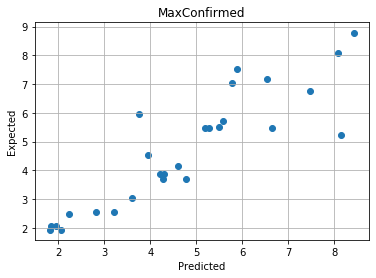

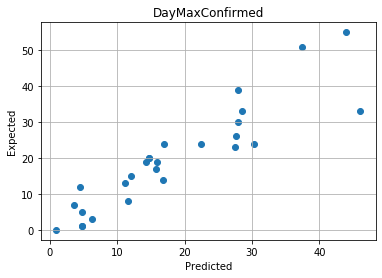

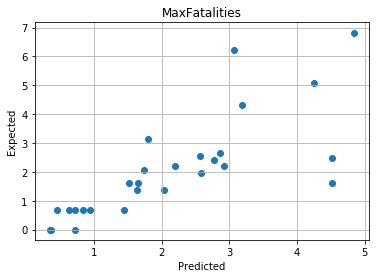

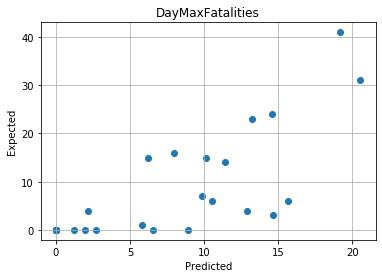

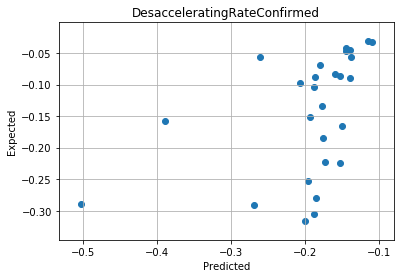

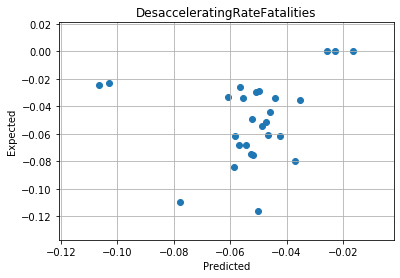

In [131]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rgr_list = []
for i in range(len(targets)):
    rgr = RandomForestRegressor(max_depth=4, random_state=0)
    rgr.fit(X_train_scaled, y_train[:,i])
    rgr_list.append(rgr)
    
    pred_train = rgr.predict(X_train_scaled)
    pred = rgr.predict(X_test_scaled)
    score = mean_squared_error(pred, y_test[:,i])
    print("Score for "+targets[i]+" :", score)
    
    fig = plt.figure()
    plt.scatter(pred, y_test[:,i])
    plt.grid()
    plt.title(targets[i])
    plt.xlabel("Predicted")
    plt.ylabel("Expected")


    plt.savefig(targets[i]+".png")

Feature ranking:
1. feature 0 (0.225785)
2. feature 2 (0.224020)
3. feature 7 (0.123112)
4. feature 8 (0.120583)
5. feature 6 (0.081144)
6. feature 5 (0.073472)
7. feature 9 (0.054501)
8. feature 10 (0.048193)
9. feature 1 (0.021120)
10. feature 4 (0.014367)
11. feature 3 (0.013702)


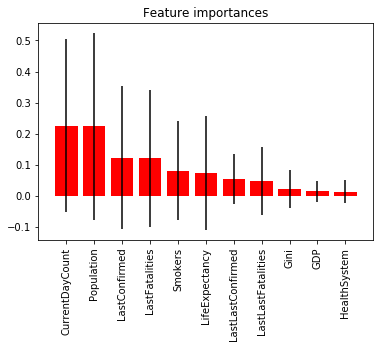

<Figure size 432x288 with 0 Axes>

In [142]:
forest = rgr_list[2]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

plt.savefig("feature_importance2.png")

In [38]:
X_scaled = scaler.fit_transform(X_imputed)

rgr_list = []
for i in range(len(targets)):
    rgr = RandomForestRegressor(max_depth=3, random_state=0)
    rgr.fit(X_scaled, y[:,i])
    rgr_list.append(rgr)


In [40]:
X = data_merged3[features][data_merged3.isCountry]
X_imputed = imputer.transform(X)
X_scaled = scaler.transform(X_imputed)

pred= []
for i in range(len(targets)):
    
    pred.append(rgr_list[i].predict(X_scaled))
    
pred = np.array(pred).T
pred[:,0] = np.exp(pred[:,0]).astype(int)
pred[:,1] = pred[:,1].astype(int)
pred[:,2] = np.exp(pred[:,2]).astype(int)
pred[:,3] = pred[:,3].astype(int)


In [41]:
pred_df = pd.DataFrame(pred)
pred_df.columns = ["Pred"+target for target in targets]

In [42]:
pred_df

,PredMaxConfirmed,PredDayMaxConfirmed,PredMaxFatalities,PredDayMaxFatalities,PredDesacceleratingRateConfirmed,PredDesacceleratingRateFatalities
0,71.0,17.0,5.0,1.0,-0.136524,-0.051483
1,45.0,16.0,3.0,2.0,-0.178029,-0.050221
2,232.0,28.0,16.0,18.0,-0.134894,-0.050977
3,42.0,9.0,3.0,0.0,-0.165176,-0.049556
4,7.0,2.0,1.0,0.0,-0.204768,-0.013409
...,...,...,...,...,...,...
179,48.0,35.0,3.0,1.0,-0.183185,-0.020873
180,28.0,24.0,2.0,0.0,-0.215960,-0.032120
181,8.0,1.0,1.0,0.0,-0.208491,-0.017712
182,9.0,4.0,1.0,0.0,-0.206651,-0.035826


In [43]:
data_pred = data_merged3[data_merged3.isCountry]
data_pred.reset_index(inplace=True)
data_pred= data_pred.assign(**pred_df)
data_pred

,index,Region,MaxConfirmed,DayMaxConfirmed,CurrentDayCount,MaxFatalities,DayMaxFatalities,LastConfirmed,LastFatalities,LastLastConfirmed,...,HealthSystem,GDP,LifeExpectancy,Smokers,PredMaxConfirmed,PredDayMaxConfirmed,PredMaxFatalities,PredDayMaxFatalities,PredDesacceleratingRateConfirmed,PredDesacceleratingRateFatalities
0,0,Afghanistan,63.0,19.0,29.0,4.0,1.0,34.0,3.0,37.0,...,1.59,4.47,64.1,NaN,71.0,17.0,5.0,1.0,-0.136524,-0.051483
1,1,Albania,29.0,25.0,32.0,4.0,2.0,17.0,0.0,7.0,...,8.42,2.06,78.5,22.4,45.0,16.0,3.0,2.0,-0.178029,-0.050221
2,2,Algeria,185.0,31.0,39.0,30.0,21.0,64.0,19.0,95.0,...,8.12,2.99,78.1,15.2,232.0,28.0,16.0,18.0,-0.134894,-0.050977
3,3,Andorra,43.0,11.0,26.0,4.0,1.0,0.0,0.0,18.0,...,21.30,NaN,NaN,32.9,42.0,9.0,3.0,0.0,-0.165176,-0.049556
4,4,Angola,4.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,...,7.18,3.79,65.0,NaN,7.0,2.0,1.0,0.0,-0.204768,-0.013409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,312,Vietnam,19.0,44.0,64.0,0.0,0.0,1.0,0.0,2.0,...,7.79,5.41,74.7,24.3,48.0,35.0,3.0,1.0,-0.183185,-0.020873
180,313,West Bank and Gaza,33.0,28.0,36.0,1.0,0.0,1.0,0.0,4.0,...,NaN,NaN,NaN,NaN,28.0,24.0,2.0,0.0,-0.215960,-0.032120
181,314,Western Sahara,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,8.0,1.0,1.0,0.0,-0.208491,-0.017712
182,315,Zambia,9.0,1.0,18.0,1.0,0.0,0.0,0.0,1.0,...,15.60,5.85,64.0,13.4,9.0,4.0,1.0,0.0,-0.206651,-0.035826


In [44]:

data_pred["PredMaxConfirmed"] = data_pred[["PredMaxConfirmed", "MaxConfirmed"]].apply(lambda x: np.max((x[0], x[1])),1)
data_pred["PredMaxFatalities"] = data_pred[["PredMaxFatalities", "MaxFatalities"]].apply(lambda x: max(x[0], x[1]),1)
data_pred["PredDayMaxConfirmed"] = data_pred[["PredDayMaxConfirmed", "DayMaxConfirmed"]].apply(lambda x: max(x[0], x[1]),1)
data_pred["PredDayMaxFatalities"] = data_pred[["PredDayMaxFatalities", "DayMaxFatalities"]].apply(lambda x: max(x[0], x[1]),1)


data_pred["PredMaxConfirmed"] = data_pred[["PredMaxConfirmed", "MaxConfirmed", "CountryType"]].apply(lambda x: x[1] if x[2]==1 else x[0],1)
data_pred["PredMaxFatalities"] = data_pred[["PredMaxFatalities", "MaxFatalities", "CountryType"]].apply(lambda x: x[1] if x[2]==1 else x[0],1)
data_pred["PredDayMaxConfirmed"] = data_pred[["PredDayMaxConfirmed", "DayMaxConfirmed", "CountryType"]].apply(lambda x: x[1] if x[2]==1 else x[0],1)
data_pred["PredDayMaxFatalities"] = data_pred[["PredDayMaxFatalities", "DayMaxFatalities", "CountryType"]].apply(lambda x: x[1] if x[2]==1 else x[0],1)
data_pred["PredDesacceleratingRateConfirmed"] = data_pred[["PredDesacceleratingRateConfirmed", "DesacceleratingRateConfirmed", "CountryType"]].apply(lambda x: x[1] if x[2]==1 else x[0],1)
data_pred["PredDesacceleratingRateFatalities"] = data_pred[["PredDesacceleratingRateFatalities", "DesacceleratingRateFatalities", "CountryType"]].apply(lambda x: x[1] if x[2]==1 else x[0],1)



# Analysis for non-countries



In [45]:
data_countries = data[data.isCountry==False][["Country_Region", "ConfirmedCases"]].groupby(["Country_Region"]).max()
data_non_countries = data[data.isCountry==False][["Province_State", "Country_Region", "ConfirmedCases"]].groupby(["Province_State", "Country_Region"]).max()
data_non_countries.reset_index(inplace=True)
data_non_countries = data_non_countries.merge(data_countries, on="Country_Region", how="left")
data_non_countries["RegionFraction"] = data_non_countries[["ConfirmedCases_x", "ConfirmedCases_y"]].apply(lambda x: x[0]/x[1], axis=1)
data_non_countries

,Province_State,Country_Region,ConfirmedCases_x,ConfirmedCases_y,RegionFraction
0,Alabama,US,3217.0,181026.0,0.017771
1,Alaska,US,257.0,181026.0,0.001420
2,Alberta,Canada,1567.0,12292.0,0.127481
3,Anguilla,United Kingdom,3.0,407.0,0.007371
4,Anhui,China,991.0,67803.0,0.014616
...,...,...,...,...,...
128,Wyoming,US,261.0,181026.0,0.001442
129,Xinjiang,China,76.0,67803.0,0.001121
130,Yukon,Canada,8.0,12292.0,0.000651
131,Yunnan,China,184.0,67803.0,0.002714


# Forecasting for countries


In [77]:
def pred_type1 (current_day, day_max_value,  max_value, desaccelerating_rate, time_horizon):
    
    x = np.arange(current_day-day_max_value , time_horizon+current_day-day_max_value)
    pred = np.exp(x*desaccelerating_rate+np.log(max_value))
    return pred


def pred_type0 (current_day, day_max_value, current_value, max_value, time_horizon):
    
    x = np.arange(current_day, current_day+time_horizon)
    x0, x1, y0, y1 = current_day, day_max_value, current_value, max_value
    
    a = (1/(x1-x0))*(np.log(y1+1)-np.log(y0+1))
    b = (1/(x1-x0))*(-x0*np.log(y1+1)+x1*np.log(y0+1))

    pred = np.exp(a*x+b)
    return pred


In [78]:
test_data = pd.read_csv(path+"test.csv")
test_data.head()

test_data["isCountry"] = test_data.Province_State.isna()
test_data.Province_State[test_data.Province_State.isna()] = ""
test_data["Region"]= test_data.Country_Region 
test_data["Region"][~test_data.isCountry]= test_data.Country_Region + "-" + test_data.Province_State

number_of_rows = test_data.shape[0]
registers_count_by_region_test = test_data[["ForecastId", "Region"]].groupby("Region").count()
registers_count_by_region_test.columns = ["Count"]
registers_count_by_region_test.reset_index(inplace=True)#
days_test = np.unique(test_data.Date)
n_days_test = len(days_test)

test_data

,ForecastId,Province_State,Country_Region,Date,isCountry,Region
0,1,,Afghanistan,2020-04-02,True,Afghanistan
1,2,,Afghanistan,2020-04-03,True,Afghanistan
2,3,,Afghanistan,2020-04-04,True,Afghanistan
3,4,,Afghanistan,2020-04-05,True,Afghanistan
4,5,,Afghanistan,2020-04-06,True,Afghanistan
...,...,...,...,...,...,...
13454,13455,,Zimbabwe,2020-05-10,True,Zimbabwe
13455,13456,,Zimbabwe,2020-05-11,True,Zimbabwe
13456,13457,,Zimbabwe,2020-05-12,True,Zimbabwe
13457,13458,,Zimbabwe,2020-05-13,True,Zimbabwe


In [79]:
np.unique(data_merged.Region)

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Australia-Australian Capital Territory',
       'Australia-New South Wales', 'Australia-Northern Territory',
       'Australia-Queensland', 'Australia-South Australia',
       'Australia-Tasmania', 'Australia-Victoria',
       'Australia-Western Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Canada-Alberta', 'Canada-British Columbia', 'Canada-Manitoba',
       'Canada-New Brunswick', 'Canada-Newfoundland and Labrador',
       'Canada-Northwest Territories', 'Canada-Nova Scotia',
       'Canada-Ontario', 'Canada-Prince Edward Island', 'Canada-Quebec',
       'Canad

In [80]:
days_to_predict = [dtime.strftime(dtime.strptime(days[-1],  "%Y-%m-%d")+timedelta(i), "%Y-%m-%d") for i in range(1,34)]
n_days_to_predict = len(days_to_predict)
concat_df = pd.DataFrame()
print(days_to_predict)

['2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14']


In [82]:
concat_df = pd.DataFrame()

for i, region in enumerate(regions):
    data_region = data[data.Region == region]
    data_merged_region = data_merged[data_merged.Region == region]
    data_pred_region = data_pred[data_pred.Region==region]
    isCountry = int(data_region.isCountry.iloc[-1])
    
    temp_df = pd.DataFrame({"Date":days_to_predict, "Country_Region": [data_region.Country_Region.iloc[0]]*n_days_to_predict, 
                            "Province_State": [data_region.Province_State.iloc[0]]*n_days_to_predict,
                            "isCountry": [data_region.isCountry.iloc[0]]*n_days_to_predict})
      
    
    if(isCountry==0):

        province = data_region.Province_State.iloc[-1]
        temp_data_non_country = data_non_countries[data_non_countries.Province_State==province]
        country = data_region.Country_Region.iloc[-1]
        data_region = data[data.Region==country]
        data_pred_region = data_pred[data_pred.Region==country]
        data_merged_region = data_merged[data_merged.Region == country]


    current_day = int(data_merged_region["CurrentDayCount"])
    day_max_confirmed = int(data_pred_region["PredDayMaxConfirmed"])
    day_max_fatalities = int(data_pred_region["PredDayMaxFatalities"])
    max_confirmed = int(data_pred_region["PredMaxConfirmed"])
    max_fatalities = int(data_pred_region["PredMaxFatalities"])
    des_confirmed = float(data_pred_region["PredDesacceleratingRateConfirmed"])
    des_fatalities = float(data_pred_region["PredDesacceleratingRateFatalities"])
    current_new_confirmed = int(data_region.NewConfirmed.iloc[-1])
    current_new_fatalities = int(data_region.NewFatalities.iloc[-1])

    current_confirmed = data_region.ConfirmedCases.iloc[-1]
    current_fatalities = data_region.Fatalities.iloc[-1]

    if(current_day < day_max_confirmed):
        print(region)

        pred_0_confirmed = pred_type0 (current_day, day_max_confirmed, current_new_confirmed, max_confirmed, day_max_confirmed-current_day)            
        pred_1_confirmed = pred_type1 (current_day, day_max_confirmed, max_confirmed, des_confirmed, n_days_to_predict-day_max_confirmed+current_day)            
        predicted_confirmed = list(pred_0_confirmed) + list(pred_1_confirmed)

    else:

        pred_1_confirmed = pred_type1 (current_day, day_max_confirmed, max_confirmed, des_confirmed, n_days_to_predict)                  
        predicted_confirmed = pred_1_confirmed

    if(current_day< day_max_fatalities):
        pred_0_fatalities = pred_type0 (current_day, day_max_confirmed, current_new_confirmed, max_confirmed, day_max_fatalities-current_day)                   
        pred_1_fatalities = pred_type1 (current_day, day_max_fatalities, max_fatalities, des_fatalities, n_days_to_predict-day_max_fatalities+current_day)            
        predicted_fatalities = list(pred_0_fatalities) + list(pred_1_fatalities)        

    else:
        pred_1_fatalities = pred_type1 (current_day, day_max_fatalities, max_fatalities, des_fatalities, n_days_to_predict)            
        predicted_fatalities = pred_1_fatalities   
        
    if(isCountry==0):
        fraction = float(temp_data_non_country.RegionFraction)
        predicted_confirmed = predicted_confirmed*fraction
        predicted_fatalities = predicted_fatalities*fraction
        
    predicted_confirmed[0] = predicted_confirmed[0] + current_confirmed
    predicted_confirmed = np.cumsum(predicted_confirmed)

    predicted_fatalities[0] = predicted_fatalities[0] + current_fatalities
    predicted_fatalities = np.cumsum(predicted_fatalities)
        
    temp_df["Region"]= temp_df.Country_Region 
    temp_df["Region"][~temp_df.isCountry] = temp_df.Country_Region + "-" + temp_df.Province_State
    
    
    
    temp_df["ConfirmedCases"] = predicted_confirmed
    temp_df["Fatalities"] = predicted_fatalities
    concat_df = pd.concat([concat_df, temp_df])

Bhutan
Burundi
Cabo Verde
Central African Republic
Chad
Gambia
Holy See
MS Zaandam
Malawi
Mauritania
Nepal
Nicaragua
Papua New Guinea
Sao Tome and Principe
Sierra Leone
South Sudan
Suriname
Timor-Leste
Western Sahara


In [83]:
current_data = data[["Date", "Country_Region", "Province_State", "ConfirmedCases", "Fatalities", "Region"]]
current_data.Province_State[current_data.Province_State.isna()] = ""
current_data = current_data.groupby(["Date", "Country_Region", "Province_State", "Region"]).max()
submission1 = test_data.merge(current_data, on=["Region", "Date"] ,  how='left')
submission2 = submission1.merge(concat_df, on= ["Region", "Date"], how="left")
submission2["ConfirmedCases"] = submission2[["ConfirmedCases_x", "ConfirmedCases_y"]].apply(lambda x: x[0] if ~np.isnan(x[0]) else x[1], axis=1)
submission2["Fatalities"] = submission2[["Fatalities_x", "Fatalities_y"]].apply(lambda x: x[0] if ~np.isnan(x[0]) else x[1], axis=1)
submission_data = pd.read_csv(path+"submission.csv")#
submission3 = submission_data[["ForecastId"]].merge(submission2[["ForecastId", "ConfirmedCases", "Fatalities" ]], on= "ForecastId", how="left")

submission3 = submission3.astype("int32")
submission3.reset_index(inplace=True)
submission3 = submission3.drop(["index"], axis=1)
submission3.to_csv("submission_generated.csv", index=False)